# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [33]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import fbeta_score, accuracy_score
% matplotlib inline

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Data investigation

### Portfolio

In [3]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [4]:
portfolio.describe()

,difficulty,duration,reward
count,10.000000,10.000000,10.000000
mean,7.700000,6.500000,4.200000
std,5.831905,2.321398,3.583915
min,0.000000,3.000000,0.000000
25%,5.000000,5.000000,2.000000
50%,8.500000,7.000000,4.000000
75%,10.000000,7.000000,5.000000
max,20.000000,10.000000,10.000000


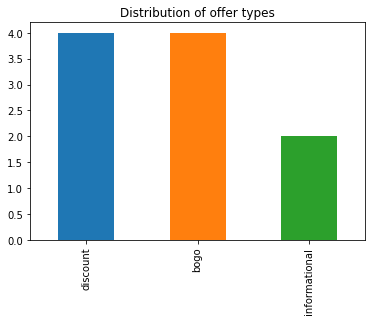

In [5]:
portfolio['offer_type'].value_counts().plot.bar(title='Distribution of offer types')

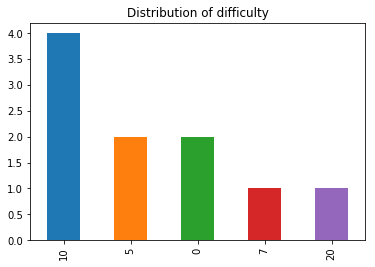

In [6]:
portfolio['difficulty'].value_counts().plot.bar(title='Distribution of difficulty')

### Profile

In [7]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [8]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


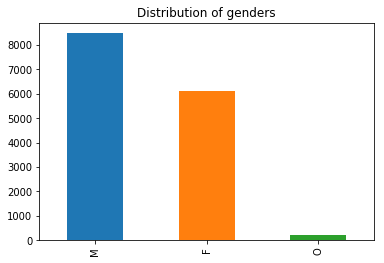

In [9]:
profile['gender'].value_counts().plot.bar(title='Distribution of genders')

### Transcript

In [10]:
transcript.tail(10)

,event,person,time,value
306524,transaction,d613ca9c59dd42f497bdbf6178da54a7,714,{'amount': 25.14}
306525,transaction,eec70ab28af74a22a4aeb889c0317944,714,{'amount': 43.58}
306526,transaction,24f56b5e1849462093931b164eb803b5,714,{'amount': 22.64}
306527,offer completed,24f56b5e1849462093931b164eb803b5,714,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...
306528,transaction,5ca2620962114246ab218fc648eb3934,714,{'amount': 2.2}
306529,transaction,b3a1272bc9904337b331bf348c3e8c17,714,{'amount': 1.5899999999999999}
306530,transaction,68213b08d99a4ae1b0dcb72aebd9aa35,714,{'amount': 9.53}
306531,transaction,a00058cf10334a308c68e7631c529907,714,{'amount': 3.61}
306532,transaction,76ddbd6576844afe811f1a3c0fbb5bec,714,{'amount': 3.5300000000000002}
306533,transaction,c02b10e8752c4d8e9b73f918558531f7,714,{'amount': 4.05}


In [11]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


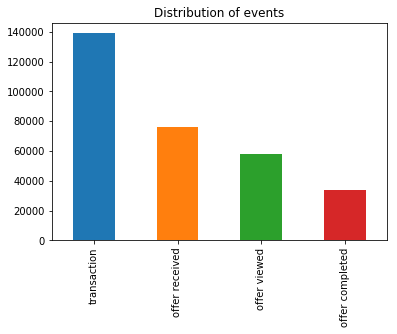

In [12]:
transcript['event'].value_counts().plot.bar(title='Distribution of events')

## Cleaning Data

### Portfolio Data
Parsing channels column value and creating new columns based on its unique values. Then removing channels column. 

In [13]:
# Clean and edit portfolio

# copy to new variable so in case of corrupting data I do not need to load them again (time saving)
portfolio_new = portfolio

portfolio_new['channels'].unique # There are 4 types of channels : web, email, mobile, social

portfolio_new['email'] = portfolio_new['channels'].apply(lambda x: 1 if 'email' in x else 0)
portfolio_new['web'] = portfolio_new['channels'].apply(lambda x: 1 if 'web' in x else 0)
portfolio_new['social'] = portfolio_new['channels'].apply(lambda x: 1 if 'social' in x else 0)
portfolio_new['mobile'] = portfolio_new['channels'].apply(lambda x: 1 if 'mobile' in x else 0)
portfolio_new = portfolio_new.drop(columns=['channels'])


In [14]:
portfolio_new.head()

,difficulty,duration,id,offer_type,reward,email,web,social,mobile
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,0,1,1
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,1,0,0


Parsing offer_type column value and creating new columns based on its unique values. Then removing offer_type column.

In [15]:
portfolio_new['offer_type'].unique() # There are 3 types of channels : bogo, informational, discount
portfolio_new['bogo'] = portfolio_new['offer_type'].apply(lambda x: 1 if 'bogo' in x else 0)
portfolio_new['informational'] = portfolio_new['offer_type'].apply(lambda x: 1 if 'informational' in x else 0)
portfolio_new['discount'] = portfolio_new['offer_type'].apply(lambda x: 1 if 'discount' in x else 0)
portfolio_new = portfolio_new.drop(columns=['offer_type'])
portfolio_new.head()

,difficulty,duration,id,reward,email,web,social,mobile,bogo,informational,discount
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,1,0,1,1,1,0,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,1,1,1,1,0,0
2,0,4,3f207df678b143eea3cee63160fa8bed,0,1,1,0,1,0,1,0
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,1,0,1,1,0,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,1,1,0,0,0,0,1


### Transcript Data

In [16]:
def getValue(row):
    '''
    INPUT:
    row - (dict) row from value column
    
    OUTPUT:
    value - (string) value from dictionary
    '''
    for key,value in row.items():
        return value

We need to take only values from column value. 

In [17]:
transcript_new = transcript

transcript_new['event'].unique() #['offer received', 'offer viewed', 'transaction', 'offer completed']
transcript_new['value'] = transcript_new['value'].apply(lambda x: getValue(x))
transcript_new[transcript_new['person'] == 'eec70ab28af74a22a4aeb889c0317944'].head(50)



,event,person,time,value
27839,transaction,eec70ab28af74a22a4aeb889c0317944,36,22.86
123493,offer received,eec70ab28af74a22a4aeb889c0317944,336,fafdcd668e3743c1bb461111dcafc2a4
127111,offer viewed,eec70ab28af74a22a4aeb889c0317944,336,fafdcd668e3743c1bb461111dcafc2a4
127112,transaction,eec70ab28af74a22a4aeb889c0317944,336,15.61
127113,offer completed,eec70ab28af74a22a4aeb889c0317944,336,fafdcd668e3743c1bb461111dcafc2a4
137412,transaction,eec70ab28af74a22a4aeb889c0317944,360,40.92
143572,transaction,eec70ab28af74a22a4aeb889c0317944,378,25.54
187123,transaction,eec70ab28af74a22a4aeb889c0317944,450,31.45
189188,transaction,eec70ab28af74a22a4aeb889c0317944,456,22.34
214231,offer received,eec70ab28af74a22a4aeb889c0317944,504,0b1e1539f2cc45b7b9fa7c272da2e1d7


Drop rows where event is a transaction. We do not need these rows in our future work.

In [18]:
t = transcript_new.drop(transcript_new[transcript_new['event']=='transaction'].index)
t = t.rename(columns={'value':'id'})
t.head()

,event,person,time,id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0


### Merging portfolio and transcript data

In [19]:
port_trans_merge = pd.get_dummies(t, columns=['event'])

port_trans_merge = port_trans_merge.drop(columns=['time'])
port_trans_merge = port_trans_merge.groupby(['person', 'id']).agg({'event_offer received':'max','event_offer viewed':'max','event_offer completed':'max'}).reset_index()
port_trans_merge = pd.merge(port_trans_merge,portfolio_new, how='left', on=['id'])
port_trans_merge.head(50)

,person,id,event_offer received,event_offer viewed,event_offer completed,difficulty,duration,reward,email,web,social,mobile,bogo,informational,discount
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1,0,1,10,7,2,1,1,0,1,0,0,1
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1,1,0,0,4,0,1,1,0,1,0,1,0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1,1,0,0,3,0,1,0,1,1,0,1,0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,5,5,5,1,1,1,1,1,0,0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,10,10,2,1,1,1,1,0,0,1
5,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,1,1,0,5,5,5,1,1,1,1,1,0,0
6,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,1,20,10,5,1,1,0,0,0,0,1
7,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,7,7,3,1,1,1,1,0,0,1
8,0011e0d4e6b944f998e987f904e8c1e5,3f207df678b143eea3cee63160fa8bed,1,1,0,0,4,0,1,1,0,1,0,1,0
9,0011e0d4e6b944f998e987f904e8c1e5,5a8bc65990b245e5a138643cd4eb9837,1,1,0,0,3,0,1,0,1,1,0,1,0


Brief look on random person's data

In [20]:
port_trans_merge[port_trans_merge['person'] == '0056df74b63b4298809f0b375a304cf4'].head(50)

,person,id,event_offer received,event_offer viewed,event_offer completed,difficulty,duration,reward,email,web,social,mobile,bogo,informational,discount
36,0056df74b63b4298809f0b375a304cf4,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,1,20,10,5,1,1,0,0,0,0,1
37,0056df74b63b4298809f0b375a304cf4,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,7,7,3,1,1,1,1,0,0,1
38,0056df74b63b4298809f0b375a304cf4,3f207df678b143eea3cee63160fa8bed,1,1,0,0,4,0,1,1,0,1,0,1,0
39,0056df74b63b4298809f0b375a304cf4,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,5,7,5,1,1,0,1,1,0,0


### Profile Data

There are missing values in income column. We will replace them with mean of income column.

In [21]:
# Clean and edit profile

# copy to new variable so in case of corrupting data I do not need to load them again (time saving)
profile_new = profile

profile_new['gender'].unique() # There are 4 types of genders : None, 'F', 'M', 'O'

profile_new['None_gender'] = profile_new['gender'].apply(lambda x: 1 if x == None else 0)
profile_new['Female'] = profile_new['gender'].apply(lambda x: 1 if x == 'F' else 0)
profile_new['Male'] = profile_new['gender'].apply(lambda x: 1 if x == 'M' else 0)
profile_new['Other_gender'] = profile_new['gender'].apply(lambda x: 1 if x == 'O' else 0)
profile_new = profile_new.drop(columns=['gender'])

profile_new['income']= profile_new['income'].fillna(profile_new['income'].mean())

profile_new = profile_new.rename(columns={'id':'person'})


In [22]:
profile_new.head()

,age,became_member_on,person,income,None_gender,Female,Male,Other_gender
0,118,20170212,68be06ca386d4c31939f3a4f0e3dd783,65404.991568,1,0,0,0
1,55,20170715,0610b486422d4921ae7d2bf64640c50b,112000.000000,0,1,0,0
2,118,20180712,38fe809add3b4fcf9315a9694bb96ff5,65404.991568,1,0,0,0
3,75,20170509,78afa995795e4d85b5d9ceeca43f5fef,100000.000000,0,1,0,0
4,118,20170804,a03223e636434f42ac4c3df47e8bac43,65404.991568,1,0,0,0


### Merging all together

In [23]:
merged = pd.merge(port_trans_merge,profile_new, how='left', on=['person'])
merged.head(50)

,person,id,event_offer received,event_offer viewed,event_offer completed,difficulty,duration,reward,email,web,...,bogo,informational,discount,age,became_member_on,income,None_gender,Female,Male,Other_gender
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1,0,1,10,7,2,1,1,...,0,0,1,33,20170421,72000.000000,0,0,1,0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1,1,0,0,4,0,1,1,...,0,1,0,33,20170421,72000.000000,0,0,1,0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1,1,0,0,3,0,1,0,...,0,1,0,33,20170421,72000.000000,0,0,1,0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,5,5,5,1,1,...,1,0,0,33,20170421,72000.000000,0,0,1,0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,10,10,2,1,1,...,0,0,1,33,20170421,72000.000000,0,0,1,0
5,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,1,1,0,5,5,5,1,1,...,1,0,0,118,20180425,65404.991568,1,0,0,0
6,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,1,20,10,5,1,1,...,0,0,1,40,20180109,57000.000000,0,0,0,1
7,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,7,7,3,1,1,...,0,0,1,40,20180109,57000.000000,0,0,0,1
8,0011e0d4e6b944f998e987f904e8c1e5,3f207df678b143eea3cee63160fa8bed,1,1,0,0,4,0,1,1,...,0,1,0,40,20180109,57000.000000,0,0,0,1
9,0011e0d4e6b944f998e987f904e8c1e5,5a8bc65990b245e5a138643cd4eb9837,1,1,0,0,3,0,1,0,...,0,1,0,40,20180109,57000.000000,0,0,0,1


Create new column based on if the offer was successful. If offer was viewed and then completed, then it means it was successful. 

In [24]:
def conditions(row):
    '''
    INPUT:
    row - (dict) row from value column
    
    OUTPUT:
    1 - if offer was successful else 0
    '''
    if (row['event_offer viewed'] == 1 and row['event_offer completed']==1):
        return 1
    else:
        return 0
merged['success'] = merged.apply(conditions, axis=1)
merged.head(50)

,person,id,event_offer received,event_offer viewed,event_offer completed,difficulty,duration,reward,email,web,...,informational,discount,age,became_member_on,income,None_gender,Female,Male,Other_gender,success
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1,0,1,10,7,2,1,1,...,0,1,33,20170421,72000.000000,0,0,1,0,0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1,1,0,0,4,0,1,1,...,1,0,33,20170421,72000.000000,0,0,1,0,0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1,1,0,0,3,0,1,0,...,1,0,33,20170421,72000.000000,0,0,1,0,0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,5,5,5,1,1,...,0,0,33,20170421,72000.000000,0,0,1,0,1
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,10,10,2,1,1,...,0,1,33,20170421,72000.000000,0,0,1,0,1
5,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,1,1,0,5,5,5,1,1,...,0,0,118,20180425,65404.991568,1,0,0,0,0
6,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,1,20,10,5,1,1,...,0,1,40,20180109,57000.000000,0,0,0,1,1
7,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,7,7,3,1,1,...,0,1,40,20180109,57000.000000,0,0,0,1,1
8,0011e0d4e6b944f998e987f904e8c1e5,3f207df678b143eea3cee63160fa8bed,1,1,0,0,4,0,1,1,...,1,0,40,20180109,57000.000000,0,0,0,1,0
9,0011e0d4e6b944f998e987f904e8c1e5,5a8bc65990b245e5a138643cd4eb9837,1,1,0,0,3,0,1,0,...,1,0,40,20180109,57000.000000,0,0,0,1,0


In [25]:
merged = pd.get_dummies(merged, columns=['id'])

In [26]:
merged.head(50)

,person,event_offer received,event_offer viewed,event_offer completed,difficulty,duration,reward,email,web,social,...,id_0b1e1539f2cc45b7b9fa7c272da2e1d7,id_2298d6c36e964ae4a3e7e9706d1fb8c2,id_2906b810c7d4411798c6938adc9daaa5,id_3f207df678b143eea3cee63160fa8bed,id_4d5c57ea9a6940dd891ad53e9dbe8da0,id_5a8bc65990b245e5a138643cd4eb9837,id_9b98b8c7a33c4b65b9aebfe6a799e6d9,id_ae264e3637204a6fb9bb56bc8210ddfd,id_f19421c1d4aa40978ebb69ca19b0e20d,id_fafdcd668e3743c1bb461111dcafc2a4
0,0009655768c64bdeb2e877511632db8f,1,0,1,10,7,2,1,1,0,...,0,0,1,0,0,0,0,0,0,0
1,0009655768c64bdeb2e877511632db8f,1,1,0,0,4,0,1,1,0,...,0,0,0,1,0,0,0,0,0,0
2,0009655768c64bdeb2e877511632db8f,1,1,0,0,3,0,1,0,1,...,0,0,0,0,0,1,0,0,0,0
3,0009655768c64bdeb2e877511632db8f,1,1,1,5,5,5,1,1,1,...,0,0,0,0,0,0,0,0,1,0
4,0009655768c64bdeb2e877511632db8f,1,1,1,10,10,2,1,1,1,...,0,0,0,0,0,0,0,0,0,1
5,00116118485d4dfda04fdbaba9a87b5c,1,1,0,5,5,5,1,1,1,...,0,0,0,0,0,0,0,0,1,0
6,0011e0d4e6b944f998e987f904e8c1e5,1,1,1,20,10,5,1,1,0,...,1,0,0,0,0,0,0,0,0,0
7,0011e0d4e6b944f998e987f904e8c1e5,1,1,1,7,7,3,1,1,1,...,0,1,0,0,0,0,0,0,0,0
8,0011e0d4e6b944f998e987f904e8c1e5,1,1,0,0,4,0,1,1,0,...,0,0,0,1,0,0,0,0,0,0
9,0011e0d4e6b944f998e987f904e8c1e5,1,1,0,0,3,0,1,0,1,...,0,0,0,0,0,1,0,0,0,0


In [27]:
data = merged.drop(columns=['person','event_offer received','event_offer viewed','event_offer completed'])
data.head(50)

,difficulty,duration,reward,email,web,social,mobile,bogo,informational,discount,...,id_0b1e1539f2cc45b7b9fa7c272da2e1d7,id_2298d6c36e964ae4a3e7e9706d1fb8c2,id_2906b810c7d4411798c6938adc9daaa5,id_3f207df678b143eea3cee63160fa8bed,id_4d5c57ea9a6940dd891ad53e9dbe8da0,id_5a8bc65990b245e5a138643cd4eb9837,id_9b98b8c7a33c4b65b9aebfe6a799e6d9,id_ae264e3637204a6fb9bb56bc8210ddfd,id_f19421c1d4aa40978ebb69ca19b0e20d,id_fafdcd668e3743c1bb461111dcafc2a4
0,10,7,2,1,1,0,1,0,0,1,...,0,0,1,0,0,0,0,0,0,0
1,0,4,0,1,1,0,1,0,1,0,...,0,0,0,1,0,0,0,0,0,0
2,0,3,0,1,0,1,1,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,5,5,5,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,1,0
4,10,10,2,1,1,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,1
5,5,5,5,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,1,0
6,20,10,5,1,1,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
7,7,7,3,1,1,1,1,0,0,1,...,0,1,0,0,0,0,0,0,0,0
8,0,4,0,1,1,0,1,0,1,0,...,0,0,0,1,0,0,0,0,0,0
9,0,3,0,1,0,1,1,0,1,0,...,0,0,0,0,0,1,0,0,0,0


## Building machine learning model

At first we need to create test and train data.

In [28]:
input_data = data.drop('success', axis=1)
label_data = data['success']
X_train, X_test, y_train, y_test = train_test_split(input_data, label_data, test_size = 0.4, random_state = 0)

The first machine learning model is Random Forest Classifier.

In [29]:
clf_rf = RandomForestClassifier(random_state = 10)
train_prediction =  (clf_rf.fit(X_train, y_train)).predict(X_train)
test_predictions = (clf_rf.fit(X_train, y_train)).predict(X_test)
rf_train_score =  accuracy_score(y_train, train_prediction)*100
rf_test_score = fbeta_score(y_test, test_predictions, beta = 0.5, average='micro' )*100
print(rf_train_score)
print(rf_test_score)

97.8299799853
74.7471954495


The accuracy of Random Forest Classifier on the train data is 97.8%. On the test data we get fbeta score 74.7%

In [30]:
clf_mlp = MLPClassifier(random_state = 10)
train_prediction_mlp =  (clf_mlp.fit(X_train, y_train)).predict(X_train)
test_predictions_mlp = (clf_mlp.fit(X_train, y_train)).predict(X_test)
train_score_mlp =  accuracy_score(y_train, train_prediction_mlp)*100
test_score_mlp = fbeta_score(y_test, test_predictions_mlp, beta = 0.5, average='micro' )*100
print(train_score_mlp)
print(test_score_mlp)

38.8496787106
38.3472902512


The accuracy of MLP Classifier on the train data is 38.8%. On the test data we get fbeta score 38.3%

In [36]:
clf_knn = KNeighborsClassifier()
train_prediction_knn =  (clf_knn.fit(X_train, y_train)).predict(X_train)
test_predictions_knn = (clf_knn.fit(X_train, y_train)).predict(X_test)
train_score_knn =  accuracy_score(y_train, train_prediction_knn)*100
test_score_knn = fbeta_score(y_test, test_predictions_knn, beta = 0.5, average='micro' )*100
print(train_score_knn)
print(test_score_knn)

77.2174233646
64.5362616527


The accuracy of kNN Classifier on the train data is 77.2%. On the test data we get fbeta score 64.5%

# Conclusion

We successfuly found a machine learning model which can predict if a specific order for specific person will be successful or not. We created three different machine learning models: kNN model, MLP model and Random Forest model. The random forest model seems to be the best of them with F score almost 75%, on the other hand MLP model is the worst with only 38% f score. The score of model could be probably better if we did more data cleaning, removing extremes etc. But we are satisified with our results for now.